## Suppl. Fig. 5 panel B Enrichment entropy

In [1]:
import os, sys, math, statistics
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from scipy.stats import median_abs_deviation, mannwhitneyu
from scipy.stats import ks_2samp, wilcoxon, kruskal
import plotly.express as px

import warnings

plt.style.use('ggplot')
plt.rcParams['pdf.fonttype'] = 42
import seaborn as sns

script_path = Path.cwd().parent.parent.parent.parent / "script"
data_path = Path.cwd().parent.parent.parent.parent / "data"
sys.path.append(str(script_path))

outpath = Path.cwd() / "output"
outpath.mkdir(exist_ok=True)

from utils.label_processing import attach_annotations

parameters

In [ ]:
pval_filter = True # use True for best results
combine_samples = False # use False for best results
normalization = False # use False for best results
pval_cutoff = 0.3
nbins = 35

## load data

In [2]:
%store -r timestamp
print(f"Timestamp: {timestamp}")   

Timestamp: 2023-10-21-imp5-for-figures


#### load volcano data


In [3]:
# define files to load
enrichment_dir = Path.cwd().parent.parent.parent / "enrichment"
volcano_csv_path = enrichment_dir / "output" / "enrichment_and_volcano_tables" / f"{timestamp}_volcano_table.csv"

try:
    # load the file
    volcano = pd.read_csv(volcano_csv_path, header=[0, 1], index_col=0)
except FileNotFoundError:
    print(f"File {volcano_csv_path} not found.\nPlease run the enrichment analysis first or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {volcano_csv_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [4]:
# attach canonical gene names
gene_name_csv = data_path / "external" / "canonical_names_and_Itzhak_data.csv"

lookup_table = pd.read_csv(gene_name_csv)
to_df = volcano["metadata"].copy()
list_of_cols_to_add = reversed(["Gene_name_canonical"])
for c in list_of_cols_to_add:
    new_col_data = attach_annotations(from_df=lookup_table, to_df=to_df, anno_col=c , from_on="Majority protein IDs", to_on="Majority protein IDs")
    volcano[("metadata", "Gene_name_canonical")] = new_col_data

# attach ground truth
ground_truth_csv = data_path / "external" / "curated_ground_truth_v9.0.csv"

lookup_table = pd.read_csv(ground_truth_csv)
to_df = volcano["metadata"].copy()
list_of_cols_to_add = reversed(["compartment"])
for c in list_of_cols_to_add:
    new_col_data = attach_annotations(from_df=lookup_table, to_df=to_df, anno_col=c, from_on="gene_name_canonical", to_on="Gene_name_canonical")
    volcano[("metadata", "curated_ground_truth_v9.0")] = new_col_data


#### load MSC data

In [5]:
# define files to load
external_dir = Path.cwd().parent.parent.parent.parent / "data" / "external"
Human_mcs_path = external_dir / "Human_mcs.txt"

try:
    # load the file
    mcs = pd.read_csv(Human_mcs_path, header=0,sep="\t")
except FileNotFoundError:
    print(f"File {Human_mcs_path} not found.\nPlease run the enrichment analysis first or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {Human_mcs_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [6]:
mcs_HEK293 = mcs[mcs["cell.line.tissue"].str.contains("HEK293")]
mcs_HEK293.shape

(580, 47)

## preprocess enrichment values

### Split the pvals and enrichments into two dataframes

In [7]:
sample_cols = [i for i in volcano.columns if i[0].startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9"))]

pval = volcano.copy()
for col in sample_cols:
    if col[1] == "enrichment":
        pval.drop(col, axis=1, inplace=True)

In [8]:
# construct a p-value dataframe
pval = volcano.copy()
for col in sample_cols:
    if col[1] == "enrichment":
        pval.drop(col, axis=1, inplace=True)

# rename the columns so that pval becomes the sample name (prepare for level drop)
new_column_names = [(i[0], i[0]) if i[1] == "pvals" else (i[0], i[1]) for i in pval.columns]
pval.columns = pd.MultiIndex.from_tuples(new_column_names)
pval = pval.droplevel(0, axis=1)

# construct an enrichment dataframe
enrichment = volcano.copy()
for col in sample_cols:
    if col[1] == "pvals":
        enrichment.drop(col, axis=1, inplace=True)

# rename the columns so that enrichment becomes the sample name (prepare for level drop)
new_column_names = [
    (i[0], i[0]) if i[1] == "enrichment" else (i[0], i[1]) for i in enrichment.columns
]
enrichment.columns = pd.MultiIndex.from_tuples(new_column_names)
enrichment = enrichment.droplevel(0, axis=1)

In [9]:
# drop WT columns

for col in enrichment.columns:
    if "WT" in col:
        enrichment.drop(col, axis=1, inplace=True)
        pval.drop(col, axis=1, inplace=True)

### Define pulldowns to use

In [10]:
samples = list(set([i[0] for i in sample_cols])) # get a tally of the samples [samples are named: experiment-bait]

bait2exp = {}
for sample in samples:
    experiment, bait = sample.split("-")
    if bait not in bait2exp:
        bait2exp[bait] = [experiment]
    else:
        bait2exp[bait] = bait2exp[bait] + [experiment]


In [11]:
pulldowns = ["12-YWHAQ","12-ACTB","09-ATG101","17-MAP1LC3B","11-CEP350","10-VPS35","07-CLTA","11-EEA1","05-NCLN",
"06-CCDC47","12-RTN4","12-SEC61B","02-COPE","03-SEC23A","11-SEC31A","14-RAB1A","07-COG8","11-GPR107",
"13-GOLGA2","03-HSPA1B","09-HSP90AA1","12-LAMP1","14-RAB7A","12-TOMM20","02-DCP1A","05-EDC4","09-PEX3",
"05-CAV1","17-ATP1B3","17-SLC30A2","09-PSMB7","13-RAB14","14-RAB11A","17-RPL36","17-CAPRIN1","17-G3BP1"]
assert all([i in samples for i in pulldowns]), "Not all pulldowns are in the data" 

compartments = ["14-3-3","actin","autophagosome","autophagosome","centrosome","endo/lysosome","endosome","endosome","ER",
"ER","ER","ER","ER/Golgi","ER/Golgi","ER/Golgi","ER/Golgi","Golgi","Golgi","Golgi","HSP70 chaperone",
"HSP90 chaperone","lysosome","lysosome","mitochondria","p-body","p-body","peroxisome","plasma membrane",
"plasma membrane","plasma membrane","proteasome","recycling endosome","recycling endosome","ribosome",
"stress granule","stress granule"]

In [12]:
counter = Counter(compartments)
print(counter)

Counter({'ER': 4, 'ER/Golgi': 4, 'Golgi': 3, 'plasma membrane': 3, 'autophagosome': 2, 'endosome': 2, 'lysosome': 2, 'p-body': 2, 'recycling endosome': 2, 'stress granule': 2, '14-3-3': 1, 'actin': 1, 'centrosome': 1, 'endo/lysosome': 1, 'HSP70 chaperone': 1, 'HSP90 chaperone': 1, 'mitochondria': 1, 'peroxisome': 1, 'proteasome': 1, 'ribosome': 1})


In [13]:
col2type = dict(zip(pulldowns, compartments))

type2cols = {}
for column, type_ in col2type.items():
    if type_ not in type2cols:
        type2cols[type_] = []
    type2cols[type_].append(column)

### Process enrichemnts

In [15]:
# p-value filter
sam_enrichment = pd.DataFrame()
if pval_filter:
    mask = pval[pulldowns] > -math.log10(pval_cutoff) #0.698970004 # 1.301029996 is -log10(0.05)  0.698970004 is -log10(0.25)
    sam_enrichment = enrichment[pulldowns].where(mask)
else:
    sam_enrichment = enrichment[pulldowns]

In [16]:
# normalization
if normalization:
    sam_enrichment = sam_enrichment.apply(lambda x: ((x - x.min()) / (x.max() - x.min())))

In [17]:
# fill NaNs with 0 and replace negative values with 0
sam_enrichment.fillna(0, inplace=True)
sam_enrichment = sam_enrichment.clip(lower = 0)

In [18]:
# get max enrichment for each compartment
comp_enrichment = pd.DataFrame()
for type_, columns in type2cols.items():
    comp_enrichment[type_] = sam_enrichment[columns].max(axis=1)

## Compute entropy and plot

In [19]:
if combine_samples:
    enrichment_to_use = comp_enrichment
else:
    enrichment_to_use = sam_enrichment

In [20]:
entropy = pd.DataFrame()

In [21]:
def calculate_entropy(probabilities, idx_to_exclude = None):
    """
    Calculate the entropy of a probability distribution.
    
    :param probabilities: array-like, probabilities for each class
    :return: entropy, a measure of uncertainty of the prediction
    """
    # remove the excluded index
    #print(probabilities)
    if idx_to_exclude:
        probabilities = np.delete(probabilities, idx_to_exclude)
    # check if probabilities sum to 1
    if np.sum(probabilities) != 1:
        # normalize probabilities to sum to 1
        probabilities = probabilities / np.sum(probabilities)

    # Replace 0s with 1s to handle log(0) case, as log(1) = 0
    probabilities = np.clip(probabilities, 1e-20, 1)
    entropy = -np.sum(probabilities * np.log(probabilities))
    return entropy

def entropy_wrapper(row):
    """
    Calculate the entropy of a probability distribution.
    
    :param probabilities: array-like, probabilities for each class
    :return: entropy, a measure of uncertainty of the prediction
    """
    idx = row.name
    compart = enrichment.loc[idx,"curated_ground_truth_v9.0"] # get the compartment for the current row by looking up the ground truth column in the enrichment table

    # get the idx of columns to exclude
    idx_to_exclude = []
    for i, j in enumerate(enrichment_to_use.columns.to_list()):
        if col2type[j] == compart:
            idx_to_exclude.append(i)
    #print(np.array(row.values))
    #print(idx_to_exclude)

    return calculate_entropy(np.array(row.values), idx_to_exclude)


In [22]:
if combine_samples:
    entropy["enrichment_entropy"] = enrichment_to_use.apply(lambda row: calculate_entropy(np.array(row.values)), axis=1)
else:
    entropy["enrichment_entropy"] = enrichment_to_use.apply(lambda row: entropy_wrapper(row), axis=1)
    
entropy['Gene_name_canonical'] = enrichment["Gene_name_canonical"]

C:\Users\duo.peng\AppData\Local\Temp\ipykernel_31720\1270498818.py:15: RuntimeWarning: invalid value encountered in divide
  probabilities = probabilities / np.sum(probabilities)


In [23]:
entropy_median = entropy["enrichment_entropy"].median()
entropy_Q1 = entropy["enrichment_entropy"].quantile(0.25)
entropy_Q3 = entropy["enrichment_entropy"].quantile(0.75)

print("Median enrichment entropy:", entropy_median)
print("1st quartile enrichment entropy:", entropy_Q1)
print("3rd quartile enrichment entropy:", entropy_Q3)

Median enrichment entropy: 1.882592741871108
1st quartile enrichment entropy: 1.5501578607889985
3rd quartile enrichment entropy: 2.232402717686064


### plot

In [24]:
entropy["in_MCSdb"] = entropy["Gene_name_canonical"].isin(mcs_HEK293["gene.symbol"])
entropy["in_MCSdb"].value_counts()

in_MCSdb_count = entropy["in_MCSdb"].value_counts()[1]
not_in_MCSdb_count = entropy["in_MCSdb"].value_counts()[0]

In [25]:
# save the column before replacing the values
annot_df = enrichment_to_use.copy()
annot_df.insert(loc=2, column = "in_MCSdb(HEK293T)", value = entropy["in_MCSdb"].copy())

# replace True with in_MCSdb and False with not_in_MCSdb
entropy["in_MCSdb"] = entropy["in_MCSdb"].replace({True: f"in MCSdb (HEK293T) n={in_MCSdb_count}", False: f"not in MCSdb (HEK293T) n={not_in_MCSdb_count}"})

In [26]:
# This function is used to create a diagonal mark on the axes
def break_indicator(ax, ax2):
    d = 0.015  # size of diagonal mark
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)         # top-left diagonal
    #ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
    kwargs.update(transform=ax2.transAxes)  # change the transform for ax2
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    #ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

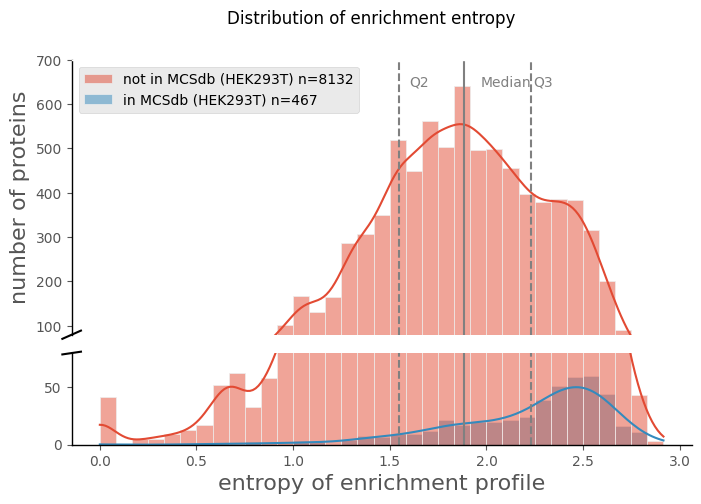

In [27]:
# Assuming 'entropy' is your DataFrame and it contains 'enrichment_entropy' and 'interfacial&MCS' columns
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5),
                              gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.1})

# Plot the same data on both axes
sns.histplot(data=entropy, x="enrichment_entropy", bins=nbins, kde=True, hue="in_MCSdb", ax=ax)
sns.histplot(data=entropy, x="enrichment_entropy", bins=nbins, kde=True, hue="in_MCSdb", ax=ax2)

# Set y-limits for the axes
ax.set_ylim(80, 700)  # Adjust the upper limit according to your data's range
ax2.set_ylim(0, 80)

# Hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False, top = False)  # Don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Apply the break indicator function
break_indicator(ax, ax2)

# Title, labels, and other aesthetics
ax2.set_xlabel("entropy of enrichment profile", fontsize=16)
ax.set_ylabel("number of proteins", fontsize=16)
ax2.set_ylabel("")
fig.suptitle("Distribution of enrichment entropy")

# Color palette and line width
color_pal = px.colors.qualitative.D3  # Ensure you have the right import for px
lw = 1.5  # This line and color_pal do not seem to be used in this snippet

# No grid and set background color for both subplots
ax.grid(False)
ax2.grid(False)
ax.set_facecolor('white')
ax2.set_facecolor('white')

# Customize axes appearance
for a in [ax, ax2]:
    a.spines['left'].set_visible(True)
    a.spines['left'].set_color('black')
    a.spines['left'].set_linewidth(1)
    a.spines['bottom'].set_visible(True)
    a.spines['bottom'].set_color('black')
    a.spines['bottom'].set_linewidth(1)

ax.spines['bottom'].set_visible(False)

# Remove the legend title
legend = ax.get_legend()
legend.set_title(None)

# remove the legend from the bottom subplot
ax2.get_legend().remove()

ax.axvline(x=entropy_median, color="gray", linestyle='-', label="median", linewidth=lw)
ax.axvline(x=entropy_Q1, color="gray", linestyle='--', label="Q1", linewidth=lw)
ax.axvline(x=entropy_Q3, color="gray", linestyle='--', label="Q3", linewidth=lw)

ax.text(entropy_median+0.35, ax.get_ylim()[1] * 0.95, 'Median', horizontalalignment='right', verticalalignment='top', color="gray")
ax.text(entropy_Q1+0.15, ax.get_ylim()[1] * 0.95, 'Q2', horizontalalignment='right', verticalalignment='top', color="gray")
ax.text(entropy_Q3+0.01, ax.get_ylim()[1] * 0.95, 'Q3', horizontalalignment='left', verticalalignment='top', color="gray")

ax2.axvline(x=entropy_median, color="gray", linestyle='-', label="median", linewidth=lw)
ax2.axvline(x=entropy_Q1, color="gray", linestyle='--', label="Q1", linewidth=lw)
ax2.axvline(x=entropy_Q3, color="gray", linestyle='--', label="Q3", linewidth=lw)

# save the plot
plt.savefig(outpath / "entropy_distribution.pdf", dpi=600, bbox_inches='tight', format='pdf')

plt.show()